In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
import os
import random
import numpy as np
import time
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
from PIL import Image
import os

directory = 'C:\\Users\\Jean-Michel\\Downloads\\my_data_aug\\my_data_aug'

for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    
    # Only process files (not directories)
    if os.path.isfile(filepath):
        try:
            with open(filepath, 'rb') as f:
                Image.open(f)
        except:
            os.remove(filepath)
            print('Removed:', filepath)


In [5]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
train_transforms = transforms.Compose([transforms.RandomResizedCrop(size=324, scale=(0.8, 1.0)),
                                      transforms.RandomRotation(degrees=5),
                                      transforms.ColorJitter(),
                                      #transforms.RandomHorizontalFlip(),
                                      transforms.CenterCrop(size=299),  # Image net standards
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])
                                      ])

test_transforms = transforms.Compose([
                           #transforms.CenterCrop((224, 224)),
                            transforms.Resize((299,299)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
                       ])

In [7]:
train_data = datasets.ImageFolder(r"C:\Users\Jean-Michel\Downloads\my_data_aug\my_data_aug\train", train_transforms)
test_data = datasets.ImageFolder(r"C:\Users\Jean-Michel\Downloads\my_data_aug\my_data_aug\test", test_transforms)
#test_data = datasets.ImageFolder('data/dogs-vs-cats/test', test_transforms)

import os

#print(len(os.listdir('my_data/train')))

n_train_examples = int(len(train_data)*0.8)
n_valid_examples = n_test_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples])
#train_data, test_data = torch.utils.data.random_split(train_data, [n_train_examples-n_valid_examples, n_test_examples])


In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 4844
Number of validation examples: 1212
Number of testing examples: 1457


In [9]:
BATCH_SIZE = 32
train_iterator = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [11]:
device = torch.device('cuda')
device

device(type='cuda')

In [13]:
import torchvision.models as models

model = models.inception_v3(pretrained=True)
model.aux_logits = False
model = model.to(device)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\Jean-Michel/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [14]:
for param in model.parameters():
    param.requires_grad = True

In [15]:
print(model.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [16]:
model.fc = nn.Linear(in_features=2048, out_features=18, bias=True).to(device)

In [17]:
optimizer = optim.Adam(model.parameters())

In [18]:
criterion = nn.CrossEntropyLoss()

In [19]:
def calculate_accuracy(fx, y):
    preds = fx.max(1, keepdim=True)[1]
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc

In [37]:
def train(model, device, iterator, optimizer, criterion):  
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
              
        fx = model(x)

        loss = criterion(fx, y)
        
        acc = calculate_accuracy(fx, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [38]:
def evaluate(model, device, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            fx = model(x)

            loss = criterion(fx, y)

            acc = calculate_accuracy(fx, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)



In [39]:
t_train_acc = []
t_val_acc = []
t_train_loss = []
t_val_loss = []

In [40]:
EPOCHS = 40

SAVE_DIR = 'models'
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'jean_inception_v3.pt')

best_valid_loss = float('inf')

if not os.path.isdir(f'{SAVE_DIR}'):
    os.makedirs(f'{SAVE_DIR}')

for epoch in range(EPOCHS):
    
    start = time.time()
    
    train_loss, train_acc = train(model, device, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, device, valid_iterator, criterion)
    
    
    t_train_loss.append(train_loss)
    t_train_acc.append(train_acc)
    
    t_val_acc.append(valid_acc)
    t_val_loss.append(valid_loss)
   
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
    
    T = time.time() - start
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:05.2f}% | T: {T:0.2f}s|')


| Epoch: 01 | Train Loss: 0.047 | Train Acc: 98.64% | Val. Loss: 0.071 | Val. Acc: 97.52% | T: 88.52s|
| Epoch: 02 | Train Loss: 0.075 | Train Acc: 98.14% | Val. Loss: 0.534 | Val. Acc: 91.64% | T: 83.62s|
| Epoch: 03 | Train Loss: 0.130 | Train Acc: 96.22% | Val. Loss: 0.081 | Val. Acc: 97.84% | T: 82.72s|
| Epoch: 04 | Train Loss: 0.044 | Train Acc: 98.73% | Val. Loss: 0.024 | Val. Acc: 99.42% | T: 83.52s|
| Epoch: 05 | Train Loss: 0.032 | Train Acc: 98.93% | Val. Loss: 0.024 | Val. Acc: 99.26% | T: 84.08s|
| Epoch: 06 | Train Loss: 0.026 | Train Acc: 99.12% | Val. Loss: 0.003 | Val. Acc: 100.00% | T: 84.89s|
| Epoch: 07 | Train Loss: 0.028 | Train Acc: 99.35% | Val. Loss: 0.009 | Val. Acc: 99.84% | T: 84.68s|
| Epoch: 08 | Train Loss: 0.044 | Train Acc: 98.77% | Val. Loss: 0.045 | Val. Acc: 98.75% | T: 84.86s|
| Epoch: 09 | Train Loss: 0.053 | Train Acc: 98.77% | Val. Loss: 0.067 | Val. Acc: 97.85% | T: 85.08s|
| Epoch: 10 | Train Loss: 0.034 | Train Acc: 99.07% | Val. Loss: 0.009 |

In [55]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
test_loss, test_acc = evaluate(model, device, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:05.2f}% |')


| Test Loss: 17.747 | Test Acc: 31.39% |


In [45]:
import matplotlib.pyplot as plt
acc = t_train_acc
val_acc = t_val_acc
loss = t_train_loss
val_loss = t_val_loss
 
epochs = range(len(acc))

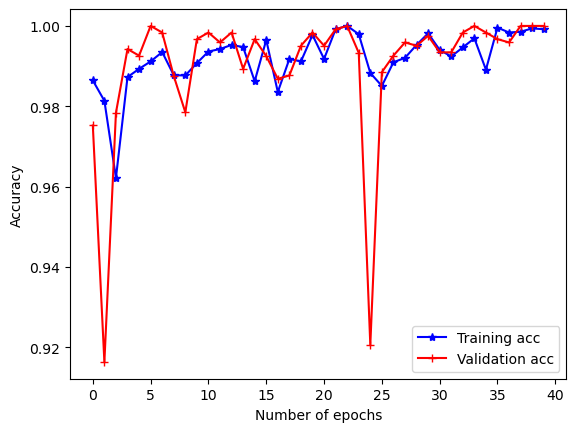

In [46]:
plt.plot(epochs, acc, 'b', label='Training acc',marker = "*")
plt.plot(epochs, val_acc, 'r', label='Validation acc',marker = "+")
#plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.savefig('trainning_resnet152_acc.png', dpi=300)
plt.show()

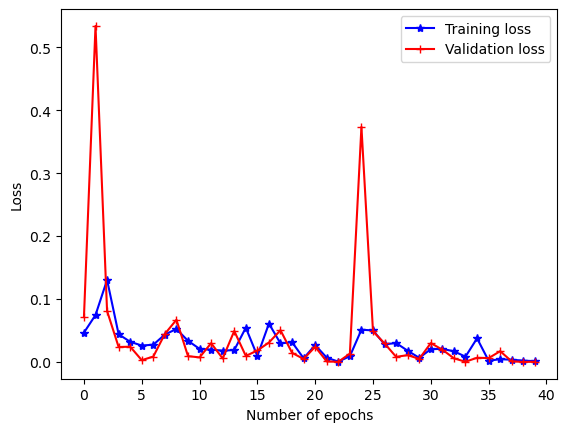

In [48]:
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss',marker = "*")
plt.plot(epochs, val_loss, 'r', label='Validation loss',marker = "+")
#plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.savefig('trainning_resnet152_loss.png', dpi=300)
plt.show()